In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

img = d2l.plt.imread('../img/catdog.jpg')

h, w = img.shape[:2]
h, w

(1667, 2500)

In [2]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    fmap = torch.zeros((1,10,fmap_h, fmap_w))
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1,2,0.5]) # generate anchors
    bbox_scale = torch.tensor((w,h,w,h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes, anchors[0]*bbox_scale)
    

/home/liwch/miniconda3/envs/d2l/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811748419/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


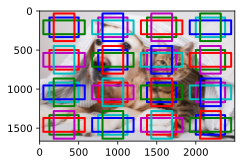

In [3]:
# feature map size: 4x4
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

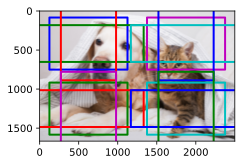

In [4]:
# feature map size: 2x2
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

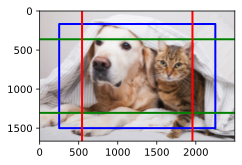

In [5]:
# feature map size: 1x1
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

# SSD Part

In [6]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [7]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    '''
    convolution for predicting classes; input channels: num_inputs; output channels:  num_anchors*(num_classes+1); the size of img will not be changed
    '''
    return nn.Conv2d(num_inputs, num_anchors*(num_classes+1), kernel_size=3, padding=1) # num_classes+1, 1 stands for background

def bbox_predictor(num_inputs, num_anchors):
    '''
    predicting bounding boxes offsets
    '''
    return nn.Conv2d(num_inputs, num_anchors*4, kernel_size=3, padding=1) # num_anchors*4, 4 stands for 4 values for bbox offsets

# the size of input may be very different
def forward(x, block):
    return block(x)
Y1 = forward(torch.zeros((2,8,20,20)), cls_predictor(8,5,10)) # 55 predicted value for each pixel
Y2 = forward(torch.zeros((2,16,10,10)), cls_predictor(16,3,10))
Y1.shape, Y2.shape


(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [8]:
# flatten pred -- the channel dim will be the last dim st. the predicted value will be gathered together
def flatten_pred(pred):
    # just put the 2nd dim(#channels) of pred to th end
    return torch.flatten(pred.permute(0,2,3,1), start_dim=1) # permute: change the dim order; start_dim=1: flatten from the 2nd dim
def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

### Net part

In [9]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2)) # down sample
    return nn.Sequential(*blk)

# forward(torch.zeros((2,3,20,20)), down_sample_blk(3, 10)).shape

def base_net():
    blk = []
    num_filters = [3,16,32,64]
    for i in range(len(num_filters)-1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

# forward(torch.zeros((2,3,256,256)), base_net()).shape

def get_blk(i):
    if i == 0:
        blk = base_net() # 3->64
    elif i == 1:
        blk = down_sample_blk(64, 128) # 64->128
    elif i == 4:
        blk = nn.AdaptiveAvgPool2d((1,1)) # imgsize = 1x1
    else:
        blk = down_sample_blk(128, 128) # 128->128
    return blk

def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X) # feature map: Y
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio) # generate anchors
    cls_preds = cls_predictor(Y) # predict class
    bbox_preds = bbox_predictor(Y) # predict bbox offsets
    return (Y, anchors, cls_preds, bbox_preds)


Hyper-parameters

In [10]:
sizes = [[0.2, 0.272],
         [0.37, 0.447],
         [0.54, 0.619],
         [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1 # num of anchors for each pixel = 4


# Model

In [11]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        # prediction on 5 different sizes
        for i in range(5):
            # set attribute
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None]*5, [None]*5, [None]*5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                                                                    getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1) # cat anchors
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes+1) # let the last dim be classes
        bbox_preds = concat_preds(bbox_preds)
        
        return anchors, cls_preds, bbox_preds

In [12]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print("anchors: ", anchors.shape) # anchors are same for all imgs, so there is no batch_size (batch_size=1, #anchors, value of each anchor)
print("class predicted: ", cls_preds.shape)
print("bbox: ", bbox_preds.shape) # 21776 = 5444*4

anchors:  torch.Size([1, 5444, 4])
class predicted:  torch.Size([32, 5444, 2])
bbox:  torch.Size([32, 21776])


In [13]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [14]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

# Loss

In [15]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none') # L2 loss may be very large

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_lables, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds*bbox_masks, bbox_lables*bbox_masks).mean(dim=1) # bbox_masks will ignore background
    return cls + bbox

def cls_eval(cls_preds, cls_lables):
    return float(
        (cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_lables).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float(
        (torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

# Training

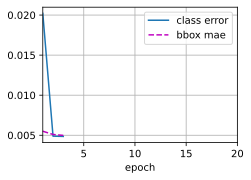

In [ ]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['class error', 'bbox mae'])
net = net.to(device)

for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')
        

# Prediction

In [ ]:
X = torchvision.io.read_image('../data/banana-detection/bananas_train/images/1.png').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)
output.shape

In [ ]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')
        
display(img, output.cpu(), threshold=0.9)